In [178]:
from modules.basics.FileIO import Dataset, DatasetProfile, WayEEG, split_dataset
import modules.basics.ExploratoryAnalysis as exp
from modules.basics.PreProcessing import SignalICA, SignalResample, SignalFilter, PipeProcess
from modules.basics.Processing import SignalEpoch, SignalMashup, SignalPrint, SignalAbs
from modules.wavelet.ExploratoryAnalysis import WtTestPlots
from modules.wavelet.Processing import SignalCWT, Domain2D
import os
import torch
import numpy as np
from modules.dataset_sinth.Regression import pipe_ts_target
import dotenv
from modules.dataset_sinth.SetProd import SaveManager, target_processing
dotenv.load_dotenv(override=True)
dataset = Dataset()
target_list=[]

pipeline = PipeProcess()
pipeline.add_step([
    SignalResample(new_fs=120, original_fs=500),
    SignalEpoch(epoch_length=1, overlap=0.9, axis=-1)
])

targets_raw = np.empty([1,3])
for i, dict in enumerate(dataset):
    data = WayEEG(dict)
    current = np.array([data.x_pos, data.y_pos, data.z_pos]).T
    if targets_raw.size > 0:
        targets_raw = np.concatenate([targets_raw, current], axis=0)
    else:
        targets_raw = current
    if i == 0:
        print(targets_raw.shape)
        break

targets = pipe_ts_target(targets_raw, pipeline, padding='zero')







Loading .mat files:   0%|          | 0/106 [00:00<?, ?it/s]

(4917, 3)


In [179]:
def plot_trajectory(targets):
    epochs, time_steps, _ = targets.shape
    # Expand the data to (epochs * time_steps, 4) where first column is the epoch index
    expanded_data = np.column_stack((
        np.repeat(np.arange(epochs), time_steps),  # Epoch indices
        targets.reshape(-1, 3)  # Flatten time and xyz
    ))
    
    # Start Napari viewer
    viewer = napari.Viewer()
    
    # Add points layer
    viewer.add_points(
        expanded_data, 
        size=0.1, 
        ndim=4,  # Treating the first dimension as a slider
        n_dimensional=True  # This enables the epoch slider
    )
    
    napari.run()


In [180]:
def max_consecutive_direction_distance(epoch_data):
    """
    Calculates the maximum consecutive direction distance for each coordinate.
    """
    diffs = np.diff(epoch_data, axis=0)  # Compute consecutive differences
    directions = np.sign(diffs)  # Get sign (-1, 0, 1)

    max_distances = np.zeros(epoch_data.shape[1])  # Store max distances per coordinate

    for coord in range(epoch_data.shape[1]):
        current_sum = 0
        max_sum = 0
        prev_direction = 0

        for i in range(len(diffs)):
            if directions[i, coord] == prev_direction or prev_direction == 0:
                current_sum += abs(diffs[i, coord])
            else:
                max_sum = max(max_sum, current_sum)
                current_sum = abs(diffs[i, coord])

            prev_direction = directions[i, coord]

        max_sum = max(max_sum, current_sum)  # Final check
        max_distances[coord] = max_sum

    return max_distances
def filter_epochs_by_max_consec_distance(data, threshold):
    """
    Removes epochs where coordinate 2 (z-axis) has a max consecutive direction distance below the given threshold.

    Parameters:
    - data: NumPy array of shape (epochs, time, 3) representing coordinates over time.
    - threshold: Minimum required max consecutive distance for coord 2.

    Returns:
    - Filtered NumPy array with valid epochs.
    """
    # Compute max consecutive distances for all epochs
    max_distances = np.array([max_consecutive_direction_distance(epoch) for epoch in data])
    
    # Extract only coord 2 distances
    valid_epochs = max_distances[:, 2] >= threshold
    filtered_data = data[valid_epochs]

    if filtered_data.size == 0:
        print("Warning: No epochs meet the threshold criteria.")
        return filtered_data  # Return empty array

    # Normalize remaining epochs
    min_vals = np.min(filtered_data, axis=1, keepdims=True)
    max_vals = np.max(filtered_data, axis=1, keepdims=True)
    normalized_data = (filtered_data - min_vals) / (max_vals - min_vals + 1e-8)  # Avoid division by zero

    return normalized_data

# Example Usage
threshold = 2  # Adjust based on your needs
print("Original shape:", targets.shape)
new_targets = filter_epochs_by_max_consec_distance(targets, threshold)
print("Filtered shape:", new_targets.shape)

Original shape: (97, 120, 3)
Filtered shape: (28, 120, 3)


In [183]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

def apply_median_filter(data, kernel_size):
    """
    Applies a median filter to smooth the data.

    Parameters:
    - data: NumPy array of shape (epochs, time, 3) representing coordinates over time.
    - kernel_size: Size of the median filter kernel.

    Returns:
    - Smoothed NumPy array with the same shape as the input data.
    """
    smoothed_data = np.zeros_like(data)
    for epoch_idx in range(data.shape[0]):
        for coord_idx in range(data.shape[2]):
            smoothed_data[epoch_idx, :, coord_idx] = median_filter(data[epoch_idx, :, coord_idx], size=kernel_size)
    return smoothed_data

# Apply median filter to interpolated data
kernel_size = 50  # Adjust kernel size as needed
smoothed_targets = apply_median_filter(new_targets, kernel_size)
plot_trajectory(smoothed_targets)

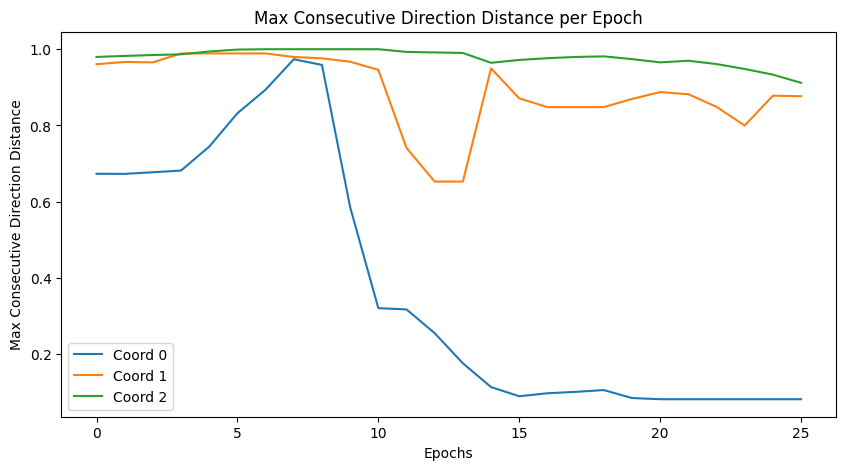

In [147]:
import numpy as np
import matplotlib.pyplot as plt

epochs, time_steps, coords = targets.shape

def max_consecutive_direction_distance(epoch_data):
    """
    Calculates the maximum consecutive direction distance for each coordinate.
    """
    diffs = np.diff(epoch_data, axis=0)  # Compute consecutive differences
    directions = np.sign(diffs)  # Get sign (-1, 0, 1)

    max_distances = np.zeros(epoch_data.shape[1])  # Store max distances per coordinate

    for coord in range(epoch_data.shape[1]):
        current_sum = 0
        max_sum = 0
        prev_direction = 0

        for i in range(len(diffs)):
            if directions[i, coord] == prev_direction or prev_direction == 0:
                current_sum += abs(diffs[i, coord])
            else:
                max_sum = max(max_sum, current_sum)
                current_sum = abs(diffs[i, coord])

            prev_direction = directions[i, coord]

        max_sum = max(max_sum, current_sum)  # Final check
        max_distances[coord] = max_sum

    return max_distances

# Compute max distances for each epoch
results = np.array([max_consecutive_direction_distance(targets[epoch]) for epoch in range(epochs)])

# Plot the results
plt.figure(figsize=(10, 5))
for coord in range(coords):
    plt.plot(results[:, coord], label=f'Coord {coord}')

plt.xlabel('Epochs')
plt.ylabel('Max Consecutive Direction Distance')
plt.legend()
plt.title('Max Consecutive Direction Distance per Epoch')
plt.show()


In [156]:
import napari

# Assuming `valid_targets` is your filtered data tensor of shape (frames, 66, 3)
trajectory_data = targets  # Your filtered targets data

# Add a time axis: reshape to (frames, points, 4) where the first column is time
n_frames, _= trajectory_data.shape

# Initialize Napari viewer
viewer = napari.Viewer(ndisplay=3)

# Add the points layer with time as the first axis
viewer.add_points(
    trajectory_data,
    size=0.01,
    ndim=3,  # Enable 3D + time (t, z, y, x)
    face_color="cyan",
    name="Centered Trajectory",
)

# Start the Napari viewer
napari.run()

'''
Very noisy mostly at the start and at the end of the task 
'''

'\nVery noisy mostly at the start and at the end of the task \n'

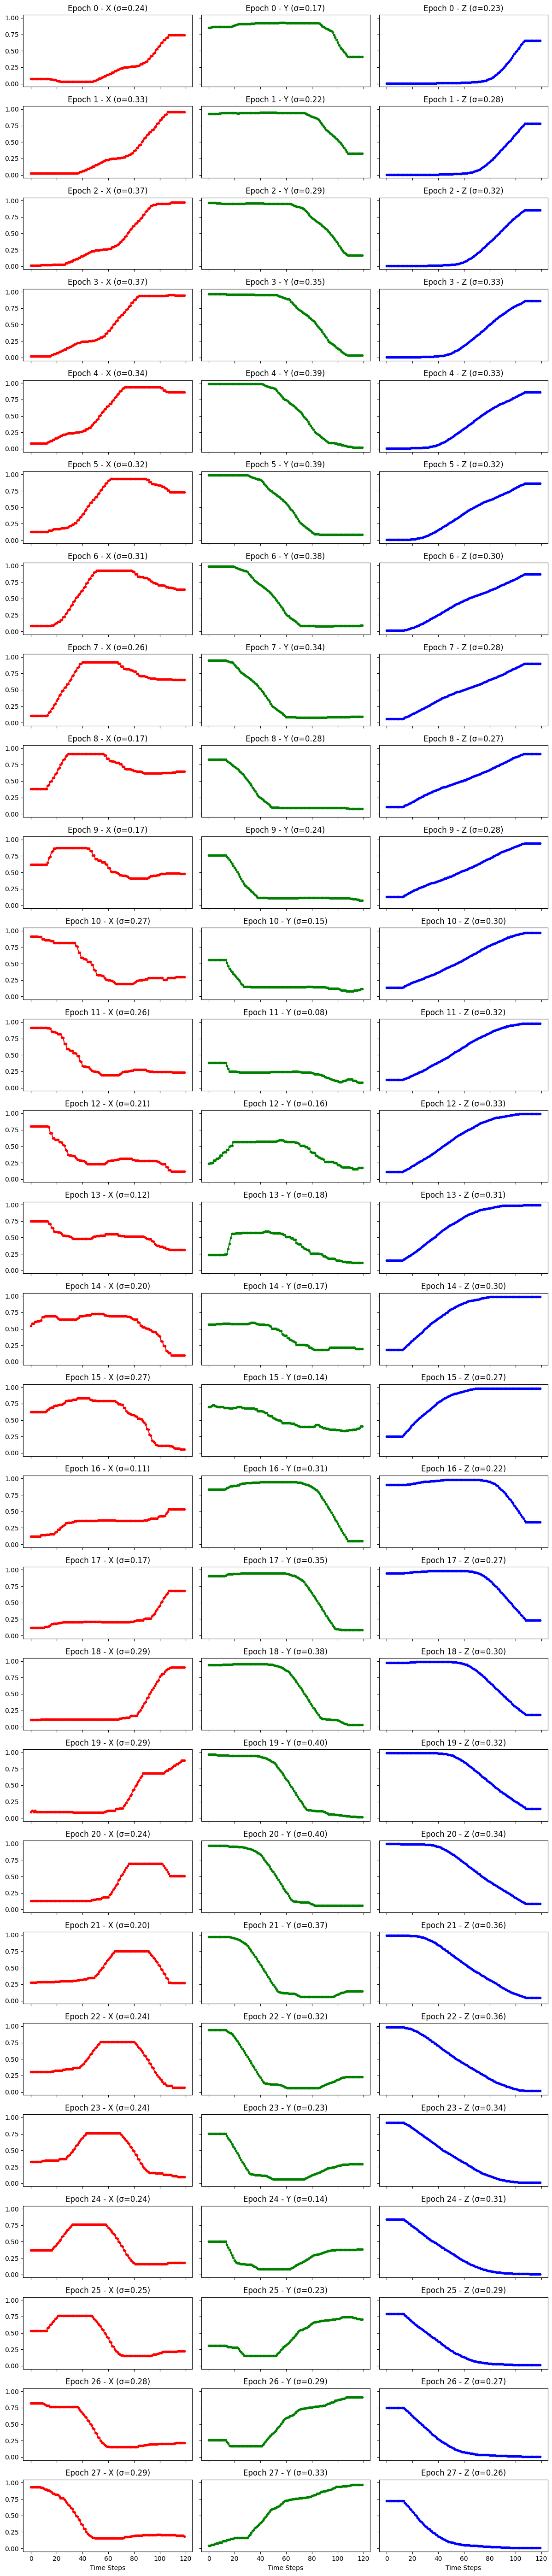

In [184]:
import numpy as np
import matplotlib.pyplot as plt
def plot_2d_traj(targets):
    epochs, time_steps, _ = targets.shape
    
    # Create Subplots
    fig, axes = plt.subplots(epochs, 3, figsize=(12, epochs * 2), sharex=True, sharey=True)
    
    for i in range(epochs):
        std_x = np.std(targets[i, :, 0])
        std_y = np.std(targets[i, :, 1])
        std_z = np.std(targets[i, :, 2])
    
        time = np.arange(time_steps)  # Time axis
    
        axes[i, 0].plot(time, targets[i, :, 0], marker='.', color='r', linestyle='-')
        axes[i, 0].set_title(f"Epoch {i} - X (σ={std_x:.2f})")
        
        axes[i, 1].plot(time, targets[i, :, 1], marker='.', color='g', linestyle='-')
        axes[i, 1].set_title(f"Epoch {i} - Y (σ={std_y:.2f})")
        
        axes[i, 2].plot(time, targets[i, :, 2], marker='.', color='b', linestyle='-')
        axes[i, 2].set_title(f"Epoch {i} - Z (σ={std_z:.2f})")
    
    axes[-1, 0].set_xlabel("Time Steps")
    axes[-1, 1].set_xlabel("Time Steps")
    axes[-1, 2].set_xlabel("Time Steps")
    
    plt.tight_layout()
    plt.show()
plot_2d_traj(smoothed_targets)

Loading .mat files:   3%|▎         | 3/106 [14:36<8:21:24, 292.08s/it]


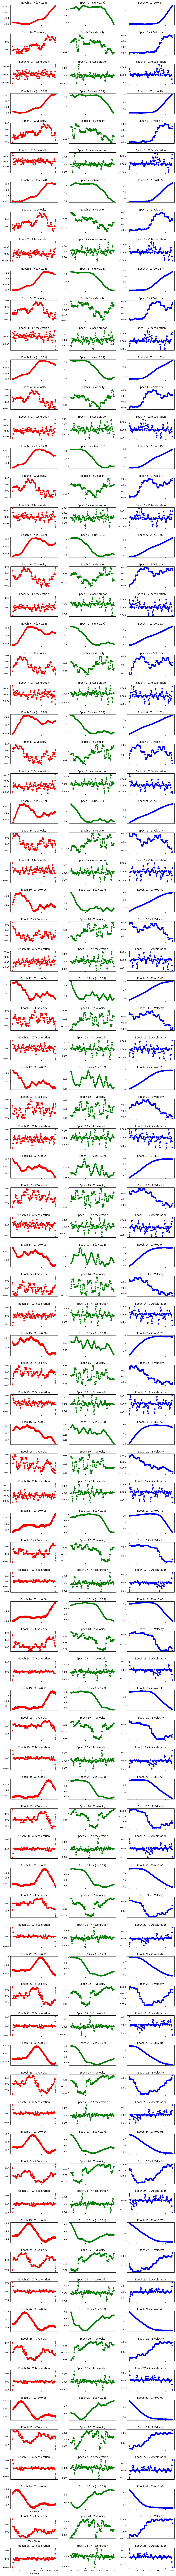

In [80]:
epochs, time_steps, _ = targets.shape

# Compute velocity and acceleration using numerical differentiation
velocity = np.gradient(targets, axis=1)  # First derivative (v = dx/dt)
acceleration = np.gradient(velocity, axis=1)  # Second derivative (a = dv/dt)

# Create Subplots: 3 rows for (Position, Velocity, Acceleration), 3 columns for (X, Y, Z)
fig, axes = plt.subplots(3 * epochs, 3, figsize=(12, 3 * epochs * 2), sharex=True, sharey=False)

for i in range(epochs):
    time = np.arange(time_steps)  # Time axis

    # Compute standard deviations
    std_x = np.std(targets[i, :, 0])
    std_y = np.std(targets[i, :, 1])
    std_z = np.std(targets[i, :, 2])

    # Position
    axes[i * 3, 0].plot(time, targets[i, :, 0], marker='o', color='r', linestyle='-')
    axes[i * 3, 0].set_title(f"Epoch {i} - X (σ={std_x:.2f})")
    
    axes[i * 3, 1].plot(time, targets[i, :, 1], marker='o', color='g', linestyle='-')
    axes[i * 3, 1].set_title(f"Epoch {i} - Y (σ={std_y:.2f})")
    
    axes[i * 3, 2].plot(time, targets[i, :, 2], marker='o', color='b', linestyle='-')
    axes[i * 3, 2].set_title(f"Epoch {i} - Z (σ={std_z:.2f})")

    # Velocity
    axes[i * 3 + 1, 0].plot(time, velocity[i, :, 0], marker='o', color='r', linestyle='--')
    axes[i * 3 + 1, 0].set_title(f"Epoch {i} - X Velocity")
    
    axes[i * 3 + 1, 1].plot(time, velocity[i, :, 1], marker='o', color='g', linestyle='--')
    axes[i * 3 + 1, 1].set_title(f"Epoch {i} - Y Velocity")
    
    axes[i * 3 + 1, 2].plot(time, velocity[i, :, 2], marker='o', color='b', linestyle='--')
    axes[i * 3 + 1, 2].set_title(f"Epoch {i} - Z Velocity")

    # Acceleration
    axes[i * 3 + 2, 0].plot(time, acceleration[i, :, 0], marker='o', color='r', linestyle=':')
    axes[i * 3 + 2, 0].set_title(f"Epoch {i} - X Acceleration")
    
    axes[i * 3 + 2, 1].plot(time, acceleration[i, :, 1], marker='o', color='g', linestyle=':')
    axes[i * 3 + 2, 1].set_title(f"Epoch {i} - Y Acceleration")
    
    axes[i * 3 + 2, 2].plot(time, acceleration[i, :, 2], marker='o', color='b', linestyle=':')
    axes[i * 3 + 2, 2].set_title(f"Epoch {i} - Z Acceleration")

# Labels
axes[-3, 0].set_xlabel("Time Steps")
axes[-2, 0].set_xlabel("Time Steps")
axes[-1, 0].set_xlabel("Time Steps")

plt.tight_layout()
plt.show()

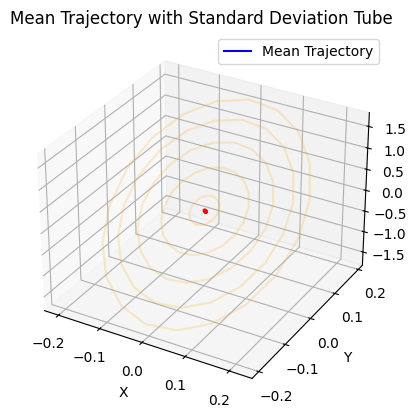

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Assume `target_list` is a list of PyTorch tensors, each of shape [66, 3]
trajectories_tensor = torch.stack(target_list)  # Shape: [num_trajectories, 66, 3]

# Compute mean and standard deviation for each timestep
mean_trajectory = trajectories_tensor.mean(dim=0)  # Shape: [66, 3]
std_trajectory = trajectories_tensor.std(dim=0)  # Shape: [66, 3]

# Convert to numpy for plotting
mean_trajectory_np = mean_trajectory.numpy()
std_trajectory_np = std_trajectory.numpy()

# Plotting
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the mean trajectory
ax.plot(mean_trajectory_np[:, 0], mean_trajectory_np[:, 1], mean_trajectory_np[:, 2], label="Mean Trajectory", color="blue")

# Function to plot tube (standard deviation) around mean trajectory
def plot_tube(ax, mean_points, std_devs, num_points=20):
    for i in range(len(mean_points)):
        # Create circular cross-section of the tube in the XY plane, scaled by std deviations
        theta = np.linspace(0, 2 * np.pi, num_points)
        circle_x = std_devs[i, 0] * np.cos(theta)
        circle_y = std_devs[i, 1] * np.sin(theta)
        circle_z = std_devs[i, 2] * np.sin(theta)  # Z deviation for visualization
        
        # Rotate and translate the circle to the current mean position
        xs = circle_x + mean_points[i, 0]
        ys = circle_y + mean_points[i, 1]
        zs = circle_z + mean_points[i, 2]
        
        # Plot the circle (tube cross-section) for each timestep
        ax.plot(xs, ys, zs, color="orange", alpha=0.2)

# Plotting the standard deviation tube
plot_tube(ax, mean_trajectory_np, std_trajectory_np)

# Optional: Scatter points along mean trajectory for better visibility
ax.scatter(mean_trajectory_np[:, 0], mean_trajectory_np[:, 1], mean_trajectory_np[:, 2], color="red", s=5)

# Set labels and title
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Mean Trajectory with Standard Deviation Tube")
ax.legend()

# Show the plot
plt.show()


In [12]:
import torch
import torch.nn.functional as F

# Sample 1D tensor with values [0, 1, 2, 3, 4]
x = torch.tensor([[[0.0, 1.0, 2.0, 3.0, 4.0]]])

# Interpolating to 10 values
print("With align_corners=True:")
print(F.interpolate(x, size=10, mode="linear", align_corners=True))

print("With align_corners=False:")
print(F.interpolate(x, size=10, mode="linear", align_corners=False))


With align_corners=True:
tensor([[[0.0000, 0.4444, 0.8889, 1.3333, 1.7778, 2.2222, 2.6667, 3.1111,
          3.5556, 4.0000]]])
With align_corners=False:
tensor([[[0.0000, 0.2500, 0.7500, 1.2500, 1.7500, 2.2500, 2.7500, 3.2500,
          3.7500, 4.0000]]])
